# DDA (Deep Discriminant Analysis)

기존의 DDA 학습은 classification base였다면 이번에는 Metric learning을 이용하여 DDA를 수행해보자.

----

Various length
-----

input frames을 100f, 200f, 400f, 800f로 잘라놓고

긴것을 앵커로 놓고 작은 것을 positive negative로 놓아 어떻게 되는지 보려고 한다.

### Environment

In [1]:
%load_ext autoreload
%autoreload 2
%pylab
%matplotlib inline

import pandas as pd
import pickle
import numpy as np
import sys
import os

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
sys.path.append('../../sv_system/')
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

### Configuration

In [3]:
from utils.parser import set_train_config
import easydict

# datasets
# voxc1_fbank_xvector
# gcommand_fbank_xvector

args = easydict.EasyDict(dict(dataset="voxc1_fbank_xvector",
                              input_frames=100, splice_frames=[50, 100], stride_frames=1, input_format='fbank',
                              cuda=True,
                              lrs=[0.1, 0.01], lr_schedule=[20], seed=1337,
                              no_eer=False,
                              batch_size=128,
                              arch="tdnn_conv", loss="softmax",
                              n_epochs=50
                             ))
config = set_train_config(args)

### Batch Sampler

In [4]:
import math
import random
import itertools

def index_dataset(dataset):
    return {c : [example_idx for example_idx, (_, class_label_ind) in \
                 enumerate(zip(dataset.embeds, dataset.labels)) if class_label_ind == c] for c in set(dataset.labels)}

def sample_from_class(images_by_class, class_label_ind):
    return images_by_class[class_label_ind][random.randrange(len(images_by_class[class_label_ind]))]

def simple(batch_size, dataset, prob_other = 0.5):
    '''lazy sampling, not like in lifted_struct. they add to the pool all postiive combinations, then compute the average number of positive pairs per image, then sample for every image the same number of negative pairs'''
    images_by_class = index_dataset(dataset)
    for batch_idx in range(int(math.ceil(len(dataset) * 1.0 / batch_size))):
        example_indices = []
        for i in range(0, batch_size, 2):
            perm = random.sample(images_by_class.keys(), 2)
            example_indices += [sample_from_class(images_by_class, perm[0]), sample_from_class(images_by_class, perm[0 if i == 0 or random.random() > prob_other else 1])]
        yield example_indices[:batch_size]

def triplet(batch_size, dataset, class2img=None):
    if class2img is not None:
        images_by_class = class2img
    else:
        images_by_class = index_dataset(dataset)
        
    for batch_idx in range(int(math.ceil(len(dataset) * 1.0 / batch_size))):
        example_indices = []
        for i in range(0, batch_size, 3):
            perm = random.sample(images_by_class.keys(), 2)
            example_indices += [sample_from_class(images_by_class, perm[0]), sample_from_class(images_by_class, perm[0]), sample_from_class(images_by_class, perm[1])]
        yield example_indices[:batch_size]

def npairs(batch_size, dataset, K = 4):
    images_by_class = index_dataset(dataset)
    for batch_idx in range(int(math.ceil(len(dataset) * 1.0 / batch_size))):
        example_indices = [sample_from_class(images_by_class, class_label_ind) for k in range(int(math.ceil(batch_size * 1.0 / K))) for class_label_ind in [random.choice(images_by_class.keys())] for i in range(K)]
        yield example_indices[:batch_size]

### Dataset

In [5]:
import torch.utils.data as data

class embedDataset(data.Dataset):
    def __init__(self, embeds, labels):
        super().__init__()
        self.embeds = embeds
        self.labels = labels
        
    def __getitem__(self, index):
        
        return self.embeds[index], self.labels[index]
    
    def __len__(self):
        
        return self.embeds.shape[0]
    
class doubleEmbedDataset(data.Dataset):
    def __init__(self, enroll_embeds, test_embeds, labels):
        super().__init__()
        self.enroll_embeds = enroll_embeds
        self.test_embeds = test_embeds
        self.labels = labels
        
    def __getitem__(self, index):
        
        return self.enroll_embeds[index], self.test_embeds[index], self.labels[index]
    
    def __len__(self):
        
        return self.enroll_embeds.shape[0]

In [6]:
def embedToDataset1(embeds, key_df):
    labels = key_df.label.tolist()
    dataset = embedDataset(embeds, labels)
    
    return dataset, embeds.shape[1], len(key_df.label.unique())

def embedToDataset2(enroll_embeds, test_embeds, key_df):
    labels = key_df.label.tolist()
    dataset = doubleEmbedDataset(enroll_embeds, test_embeds, labels)
    
    return dataset, enroll_embeds.shape[1], len(key_df.label.unique())

In [7]:
def key2df(keys):
    key_df = pd.DataFrame(keys, columns=['key'])
    key_df['spk'] = key_df.key.apply(lambda x: x.split("-")[0])
    key_df['label'] = key_df.groupby('spk').ngroup()
    key_df['origin'] = key_df.spk.apply(lambda x: 'voxc2' if x.startswith('id') else 'voxc1')
    
    return key_df

In [8]:
def refeat_df(key_df, n_repeat, suffix):
    repeat_key_df = key_df.loc[key_df.index.repeat(n_repeat)]
    repeat_key_df = repeat_key_df.set_index('key')
    repeat_key_df.index = repeat_key_df.index + '-' + suffix + '-' + \
                    repeat_key_df.groupby(level=0).cumcount().astype(str) 
    
    return repeat_key_df

In [9]:
trial = pd.read_pickle("/dataset/SV_sets/voxceleb12/dataframes/voxc12_test_trial.pkl")

In [10]:
si_keys = pickle.load(open("./embeddings_for_dda/voxc1_mfcc30/100f_embeds/si_keys.pkl", "rb"))
sv_keys = pickle.load(open("./embeddings_for_dda/voxc1_mfcc30/100f_embeds/sv_keys.pkl", "rb"))

In [11]:
# si_100f_embeds = np.load("./embeddings_for_dda/voxc1_mfcc30/100f_embeds/si_embeds.npy")
# sv_100f_embeds = np.load("./embeddings_for_dda/voxc1_mfcc30/100f_embeds/sv_embeds.npy")

In [12]:
si_200f_embeds = np.load("./embeddings_for_dda/voxc1_mfcc30/200f_embeds/si_embeds.npy")
si_200f_embeds = si_200f_embeds[:,0,:]
sv_200f_embeds = np.load("./embeddings_for_dda/voxc1_mfcc30/200f_embeds/sv_embeds.npy")
sv_200f_embeds = sv_200f_embeds[:,0,:]

In [13]:
# si_400f_embeds = np.load("./embeddings_for_dda/voxc1_mfcc30/400f_embeds/si_embeds.npy")
# sv_400f_embeds = np.load("./embeddings_for_dda/voxc1_mfcc30/400f_embeds/sv_embeds.npy")

In [14]:
si_800f_embeds = np.load("./embeddings_for_dda/voxc1_mfcc30/800f_embeds/si_embeds.npy")
sv_800f_embeds = np.load("./embeddings_for_dda/voxc1_mfcc30/800f_embeds/sv_embeds.npy")

In [15]:
si_key_df = key2df(si_keys)
sv_key_df = key2df(sv_keys)

In [16]:
# si_key_100f_df = refeat_df(si_key_df, 8, '100f')
si_key_200f_df = refeat_df(si_key_df, 4, '200f')
# si_key_400f_df = refeat_df(si_key_df, 2, '400f')
si_key_800f_df = refeat_df(si_key_df, 1, '800f')

### Choose a embedding

In [159]:
si_enroll_key_df = si_key_df
si_test_key_df = si_key_df
si_enroll_embeds = si_800f_embeds
si_test_embeds = si_200f_embeds
sv_enroll_embeds = sv_800f_embeds
sv_test_embeds = sv_200f_embeds

In [160]:
total_si_embeds = np.concatenate([si_enroll_embeds, si_test_embeds], axis=0)
total_si_key_df = pd.concat([si_key_df, si_key_df])

### LDA on embedding

In [19]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
embed_dim = 200
global_mean = total_si_embeds.mean(0)
clf = LDA(solver='svd', n_components=200)
clf.fit(total_si_embeds - global_mean, total_si_key_df.label)

LinearDiscriminantAnalysis(n_components=200, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [20]:
si_enroll_embeds = clf.transform(si_enroll_embeds - global_mean).astype(np.float32)

In [21]:
si_test_embeds = clf.transform(si_test_embeds - global_mean).astype(np.float32)

In [22]:
sv_enroll_embeds = clf.transform(sv_enroll_embeds - global_mean).astype(np.float32)

In [23]:
sv_test_embeds = clf.transform(sv_test_embeds - global_mean).astype(np.float32)

In [24]:
si_dataset, embed_dim, n_labels = embedToDataset2(si_enroll_embeds, si_test_embeds, si_key_df)
sv_dataset, _, _ = embedToDataset2(sv_enroll_embeds, sv_test_embeds, sv_key_df)

### Dataloader

In [25]:
n_pairs_per_batch = 46
batch_size = n_pairs_per_batch * 3

In [26]:
adapt_sampler = lambda batch, dataset, sampler, **kwargs: \
type('', (torch.utils.data.sampler.Sampler,), 
     dict(__len__ = dataset.__len__, __iter__ = \
          lambda _: itertools.chain.from_iterable(sampler(batch, dataset, **kwargs))))(dataset)

In [27]:
# use values to exclude unnecessary index
si_key_df['num_id'] = range(len(si_key_df))
class2idx = si_key_df.groupby('label').apply(lambda x: x.num_id.values).to_dict()

In [28]:
import torch
from torch.utils.data.dataloader import DataLoader

si_loader = torch.utils.data.DataLoader(
    si_dataset, 
    sampler = adapt_sampler(batch_size, 
                           si_dataset, 
                           triplet, 
                           class2img=class2idx), 
    num_workers = 8, batch_size = batch_size, 
    drop_last = True, pin_memory = True
)

sv_loader = DataLoader(sv_dataset, batch_size=128, num_workers=4, shuffle=False)

### Model Define

In [134]:
import torch.nn as nn

class dda_model(nn.Module):
    def __init__(self, in_dims, n_labels):
        super().__init__()
                
        hid_dims = in_dims*2
        out_dims = in_dims*2
        
        self.hidden_layer = nn.Sequential(
            nn.Linear(in_dims, hid_dims),
            nn.BatchNorm1d(hid_dims),
            nn.PReLU(),
            nn.Linear(hid_dims, hid_dims),
            nn.BatchNorm1d(hid_dims),
            nn.PReLU(),
        )    
    
        self.embedding_layer = nn.Linear(hid_dims, out_dims)
        
    def embed(self, x):
        x = self.hidden_layer(x)
#         x = self.embedding_layer(x)
    
        return x
    
    def forward(self, x):           
        x = self.embed(x)
        
        return x

### Metric Learning

In [30]:
def hard_mining(anchor, pos_egs, neg_egs, margin=1.0):
    pos_dist = (anchor - pos_egs).pow(2).sum(1)
    pos_dist = torch.clamp(pos_dist, min=1e-16)
    pos_dist = pos_dist.sqrt()
    
    neg_dist = (anchor - neg_egs).pow(2).sum(1)
    neg_dist = torch.clamp(neg_dist, min=1e-16)
    neg_dist = neg_dist.sqrt()
    
    
    hard_pos_dist = pos_dist.max()
    hard_neg_dist = neg_dist.min()
    
#     print(f"hard_pos:{hard_pos_dist}, hard_neg:{hard_neg_dist}")
    
    triplet_loss = torch.clamp(hard_pos_dist - hard_neg_dist + margin, min=0)
    triplet_loss = torch.sum(triplet_loss)
    
    return triplet_loss

In [31]:
model = dda_model(embed_dim, n_labels) 

if not config['no_cuda']:
    model = model.cuda()

In [37]:
from train.train_utils import set_seed, find_optimizer
from torch.optim.lr_scheduler import ReduceLROnPlateau, MultiStepLR
from sklearn.metrics import roc_curve
import torch.nn.functional as F
from tensorboardX import SummaryWriter

config['lrs'] = [0.01]
_, optimizer = find_optimizer(config, model)
criterion = nn.TripletMarginLoss(margin=5, p=2)
# criterion = hard_mining
# criterion = nn.CosineEmbeddingLoss(margin=0.5)
plateau_scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=5)
step_scheduler = MultiStepLR(optimizer, [30], 0.1)

writer = SummaryWriter("logs/xvector_eucl_semi_hard_m0.4_lr0.01.tf.log")

best_eer = 1.0
for epoch_idx in range(0, config['n_epochs']):
    print("-"*30)
    curr_lr = optimizer.state_dict()['param_groups'][0]['lr']
    print("curr_lr: {}".format(curr_lr))
    
#=============== train code ===============
    model.train()
    loss_sum = 0
    n_corrects = 0
    total = 0
    for batch_idx, (X_enroll, X_test, y) in enumerate(si_loader):
        if not config['no_cuda']:
            X_enroll = X_enroll.cuda()
            X_test = X_test.cuda()
            y = y.cuda()

        optimizer.zero_grad()
#         n_sub_utter = x_enroll.size(1)
        anchor = model(X_enroll[0:batch_size:3])
        pos_egs = model(X_test[1:batch_size:3])
        neg_egs = model(X_test[2:batch_size:3])
#         embeds = embeds / embeds.norm(dim=1,keepdim=True)
#         anchor = embeds[0:batch_size:3]
#         pos_egs = test_out[1:batch_size:3]
#         neg_egs = test_out[2:batch_size:3]
        loss = criterion(anchor, pos_egs, neg_egs)
        
#         loss_pos = criterion(anchor, pos_egs, torch.ones(len(anchor)).cuda())
#         loss_neg = criterion(anchor, neg_egs, torch.zeros(len(anchor)).cuda())
#         loss = loss_pos + loss_neg
        loss.backward()
        optimizer.step()
                        
        loss_sum += loss.item()
        total += y.size(0)
        if (batch_idx+1) % 1000 == 0:
            print("Batch {}/{}\t Loss {:.6f}" \
                  .format(batch_idx+1, len(si_loader), loss_sum / total))
    train_loss = loss_sum / total
    plateau_scheduler.step(train_loss)
    
    print("epoch #{}, train loss: {}".format(epoch_idx, train_loss))
    writer.add_scalar("train/loss", train_loss, epoch_idx+1)

#=============== test code ===============
    enroll_embeddings = []
    test_embeddings = []
    model.eval()

    with torch.no_grad():
        for batch in sv_loader:
            X_enroll, X_test, _ = batch
            if not config['no_cuda']:
                X_enroll = X_enroll.cuda()
                X_test = X_test.cuda()
                
            enroll_embeddings += [model.embed(X_enroll).cpu().detach()]
            test_embeddings += [model.embed(X_test).cpu().detach()]
            
        enroll_embeddings = torch.cat(enroll_embeddings)
        test_embeddings = torch.cat(test_embeddings)
        
#         score_vector = F.cosine_similarity(enroll_embeddings[trial.enrolment_id],
#                                       test_embeddings[trial.test_id], dim=1)
    score_vector = -torch.pow(
        (enroll_embeddings[trial.enrolment_id] - test_embeddings[trial.test_id]), 2).sum(dim=1).sqrt()
    label_vector = np.array(trial.label)
    fpr, tpr, thres = roc_curve(
            label_vector, score_vector, pos_label=1)
    eer = fpr[np.nanargmin(np.abs(fpr - (1 - tpr)))]
    
    if eer < best_eer:
        best_eer = eer
        print("best eer!")
        torch.save(model.state_dict(), open("best_model_metric.pt", "wb"))
        
    print("epoch #{}, sv eer: {}".format(epoch_idx, eer))
    writer.add_scalar("sv_test/eer", eer, epoch_idx+1)

------------------------------
curr_lr: 0.01
Batch 1000/1077	 Loss 0.001412
epoch #0, train loss: 0.0013891821956903644
best eer!
epoch #0, sv eer: 0.11373276776246023
------------------------------
curr_lr: 0.01
Batch 1000/1077	 Loss 0.001276
epoch #1, train loss: 0.0012694962125568727
epoch #1, sv eer: 0.11489925768822906
------------------------------
curr_lr: 0.01
Batch 1000/1077	 Loss 0.001353
epoch #2, train loss: 0.0013745728295800313
epoch #2, sv eer: 0.11611876988335101
------------------------------
curr_lr: 0.01
Batch 1000/1077	 Loss 0.001339
epoch #3, train loss: 0.001333744586943375
epoch #3, sv eer: 0.11601272534464475
------------------------------
curr_lr: 0.01
Batch 1000/1077	 Loss 0.001271
epoch #4, train loss: 0.0012802807517652292
epoch #4, sv eer: 0.12009544008483564
------------------------------
curr_lr: 0.01
Batch 1000/1077	 Loss 0.001287
epoch #5, train loss: 0.0012899171068325836
best eer!
epoch #5, sv eer: 0.11283138918345705
------------------------------
cu

In [184]:
torch.norm((anchor - pos_egs), dim=1).sqrt() - torch.norm((anchor - neg_egs), dim=1).sqrt()

tensor([-2.1443, -1.7407, -2.3529, -3.1445, -2.3549, -1.5786, -3.8178, -2.6843,
        -0.8126, -1.5916, -2.2001, -0.0664, -2.3288, -1.9027, -2.3031, -2.2385,
        -2.9484, -2.0301, -2.1811, -2.4052, -2.7927, -2.2329,  0.1192, -0.3918,
        -0.6445, -2.8001, -2.9759, -2.7587, -1.5720, -3.4203, -1.8746, -1.5057,
        -2.7930, -2.5636, -2.6269, -2.5903, -2.6227, -2.2909, -3.5267, -3.4453,
        -2.0478, -2.5677, -1.3020, -2.5305, -2.6094, -2.5658],
       device='cuda:0', grad_fn=<ThSubBackward>)

In [135]:
model1 = dda_model(200, 10)

In [118]:
torch.save(model.state_dict(), open("best_model_800f_200f.pt", "wb"))

In [137]:
saved_state = torch.load(open("best_model_800f_200f.pt", "rb"))

In [138]:
model1.load_state_dict(saved_state)
model1 = model1.cuda()

In [144]:
enroll_embeddings = []
test_embeddings = []
with torch.no_grad():
    for batch in sv_loader:
        X_enroll, X_test, _ = batch
        if not config['no_cuda']:
            X_enroll = X_enroll.cuda()
            X_test = X_test.cuda()

        enroll_embeddings += [model.embed(X_enroll).cpu().detach()]
        test_embeddings += [model.embed(X_test).cpu().detach()]

    enroll_embeddings = torch.cat(enroll_embeddings)
    test_embeddings = torch.cat(test_embeddings)

In [150]:
si_embeddings = []
with torch.no_grad():
    for batch in si_loader:
        X_enroll, _, _ = batch
        if not config['no_cuda']:
            X_enroll = X_enroll.cuda()
#             X_test = X_test.cuda()

        si_embeddings += [model.embed(X_enroll).cpu().detach()]
#         test_embeddings += [model.embed(X_test).cpu().detach()]

    si_embeddings = torch.cat(si_embeddings)

In [140]:
enroll_embeddings = torch.from_numpy(sv_enroll_embeds)
test_embeddings = torch.from_numpy(sv_test_embeds)

In [164]:
# score_vector = F.cosine_similarity(enroll_embeddings[trial.enrolment_id],
#                                   test_embeddings[trial.test_id], dim=1)
score_vector = -torch.pow((enroll_embeddings[trial.enrolment_id] - test_embeddings[trial.test_id]), 2).sum(dim=1).sqrt()
label_vector = np.array(trial.label)
fpr, tpr, thres = roc_curve(
        label_vector, score_vector, pos_label=1)
eer = fpr[np.nanargmin(np.abs(fpr - (1 - tpr)))]
print("epoch #{}, sv eer: {}".format(epoch_idx, eer))

epoch #49, sv eer: 0.10795334040296925


In [169]:
pos_score = score_vector.numpy()[label_vector==1]
neg_score = score_vector.numpy()[label_vector==0]

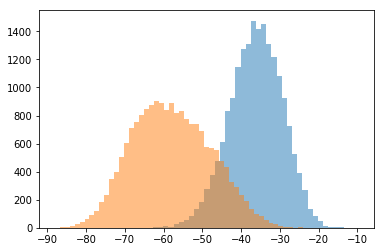

In [179]:
plt.hist(pos_score, alpha=0.5, bins=50)
plt.hist(neg_score, alpha=0.5, bins=50)
plt.show()

In [180]:
# save feature for PLDA

os.makedirs("voxc1_mfcc30_best_800f_200f")
np.save("voxc1_mfcc30_best_800f_200f/sv_enroll_embeds.npy", enroll_embeddings)
np.save("voxc1_mfcc30_best_800f_200f/sv_test_embeds.npy", test_embeddings)
np.save("voxc1_mfcc30_best_800f_200f/si_embeds.npy", si_embeddings)

import shutil

shutil.move("./embeddings_for_dda/voxc1_mfcc30/100f_embeds/si_keys.pkl", "voxc1_mfcc30_best_800f_200f/si_keys.pkl")
shutil.move("./embeddings_for_dda/voxc1_mfcc30/100f_embeds/sv_keys.pkl", "voxc1_mfcc30_best_800f_200f/sv_keys.pkl")

FileExistsError: [Errno 17] File exists: 'voxc1_mfcc30_best_800f_200f'